# Alignment

This notebook covers [*alignment*](https://pandas.pydata.org/docs/user_guide/dsintro.html#dsintro-alignment), a feature of pandas that's crucial to using it well. It relies on the pandas' handling of *labels*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Goal: Compute Real GDP

Let's learn through an example: Gross Domestic Product (the total output of a country) is measured in dollars. This means we we can't just compare the GDP from 1950 to the GDP from 2000, since the value of a dollar changed over that time (inflation).

In the US, the Bureau of Economic Analysis already provides an estimate of real GDP, but we'll calculate something similar using the formula:

$$
real\_GDP = \frac{nominal\_GDP}{price\_index}
$$

I've downloaded a couple time series from [FRED](https://fred.stlouisfed.org), one for GDP and one for the Consumer Price Index.

* U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, October 31, 2020.
* U.S. Bureau of Economic Analysis, Gross Domestic Product [GDP], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GDP, October 31, 2020.


We're going to do things the wrong way first.

In [5]:
gdp_bad = pd.read_csv("data/GDP.csv.gz", parse_dates=["DATE"])
cpi_bad = pd.read_csv("data/CPIAUCSL.csv.gz", parse_dates=["DATE"])

Our formula says `real_gdp = gdp / cpi`, so, let's try it!

In [6]:
%xmode plain

gdp_bad / cpi_bad

Exception reporting mode: Plain


TypeError: cannot perform __truediv__ with this index type: DatetimeArray

Whoops, what happened? We should probably look at our data:

In [7]:
gdp_bad

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
290,2019-07-01,21540.325
291,2019-10-01,21747.394
292,2020-01-01,21561.139
293,2020-04-01,19520.114


In [8]:
gdp_bad.dtypes

DATE    datetime64[ns]
GDP            float64
dtype: object

In [11]:
gdp_bad['DATE'][0]  # Select first observation

Timestamp('1947-01-01 00:00:00')

So, we've tried to divide a datetime by a datetime, and pandas has correctly raised a type error. That raises another issue though. These two timeseries have different frequencies.

In [12]:
cpi_bad.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [13]:
cpi_bad.dtypes

DATE        datetime64[ns]
CPIAUCSL           float64
dtype: object

CPI is measured monthly, while GDP is quarterly. What we'd really need to do is *join* the two timeseries on the `DATE` variable, and then do the operation. We could do that, but let's do things the pandorable way first.

A DataFrame is a 2-D data structure composed of three components:

1. The *values*, the actual data
2. The *row labels*, stored in a `pandas.Index` class, accessible with `.index`
3. The *column labels*, stored in a `pandas.Index` class, accessible with `.columns`


![](https://pandas.pydata.org/docs/_images/01_table_dataframe1.svg)

We'll use the *index* to store our *labels* (the dates). Then the only thing in the values is our observations (the GDP or CPI).

In [14]:
# Notice that we select the GDP column to convert the
# 1-column DataFrame to a 1D Series
gdp = pd.read_csv('data/GDP.csv.gz', index_col='DATE',
                  parse_dates=['DATE'])["GDP"]
gdp.head()

DATE
1947-01-01    243.164
1947-04-01    245.968
1947-07-01    249.585
1947-10-01    259.745
1948-01-01    265.742
Name: GDP, dtype: float64

Notice that we selected the single column `"GDP"` using `[]`. This returns a `pandas.Series` object, a 1-D array *with row labels*.

![](https://pandas.pydata.org/docs/_images/01_table_series.svg)

In [20]:
type(gdp)

pandas.core.series.Series

In [21]:
gdp.index

DatetimeIndex(['1947-01-01', '1947-04-01', '1947-07-01', '1947-10-01',
               '1948-01-01', '1948-04-01', '1948-07-01', '1948-10-01',
               '1949-01-01', '1949-04-01',
               ...
               '2018-04-01', '2018-07-01', '2018-10-01', '2019-01-01',
               '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-01',
               '2020-04-01', '2020-07-01'],
              dtype='datetime64[ns]', name='DATE', length=295, freq=None)

The actual values are a NumPy array of floats.

In [22]:
gdp.to_numpy()[:10]

array([243.164, 245.968, 249.585, 259.745, 265.742, 272.567, 279.196,
       280.366, 275.034, 271.351])

Let's read in CPI as well.

In [23]:
cpi = pd.read_csv('data/CPIAUCSL.csv.gz', index_col='DATE',
                  parse_dates=['DATE'])["CPIAUCSL"]
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

And let's try the formula again.

In [24]:
rgdp = gdp / cpi
rgdp

DATE
1947-01-01    11.320484
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.180364
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    81.777171
2020-08-01          NaN
2020-09-01          NaN
Length: 885, dtype: float64

**What happened?**

We've gotten our answer, but is there anything in the output that's surprising? What are these `NaN`s?

In pandas, any time you do an operation involving multiple pandas objects (dataframes, series), pandas will *align* the inputs. Alignment is a two-step process:

1. Take the union of the labels
2. Reindex the all inputs to the union of the labels, introducing NAs where there's new values.

Only after that does the operation (division in this case) happen.

Looking at the raw data, we see that CPI is measured monthly, while GDP is just measured quarterly. So pandas has aligned the two (to monthly frequency, since that's the union), inserting missing values where there weren't any previously.

In [25]:
# manual alignment, just for demonstration:

all_dates = gdp.index.union(cpi.index)
all_dates

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', name='DATE', length=885, freq='MS')

In [27]:
gdp

DATE
1947-01-01      243.164
1947-04-01      245.968
1947-07-01      249.585
1947-10-01      259.745
1948-01-01      265.742
                ...    
2019-07-01    21540.325
2019-10-01    21747.394
2020-01-01    21561.139
2020-04-01    19520.114
2020-07-01    21157.635
Name: GDP, Length: 295, dtype: float64

In [28]:
# Introduce NaN's when we reindex gdp to all dates
gdp2 = gdp.reindex(all_dates)
gdp2

DATE
1947-01-01      243.164
1947-02-01          NaN
1947-03-01          NaN
1947-04-01      245.968
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    21157.635
2020-08-01          NaN
2020-09-01          NaN
Freq: MS, Name: GDP, Length: 885, dtype: float64

In [29]:
# No NaN's when we go the other way though
cpi2 = cpi.reindex(all_dates)
cpi2

DATE
1947-01-01     21.480
1947-02-01     21.620
1947-03-01     22.000
1947-04-01     22.000
1947-05-01     21.950
               ...   
2020-05-01    255.768
2020-06-01    257.214
2020-07-01    258.723
2020-08-01    259.681
2020-09-01    260.209
Freq: MS, Name: CPIAUCSL, Length: 885, dtype: float64

In [30]:
rgdp2 = gdp2 / cpi2
rgdp2

DATE
1947-01-01    11.320484
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.180364
1947-05-01          NaN
                ...    
2020-05-01          NaN
2020-06-01          NaN
2020-07-01    81.777171
2020-08-01          NaN
2020-09-01          NaN
Freq: MS, Length: 885, dtype: float64

So when we wrote

```python
rgdp = gdp / cpi
```

pandas performs

```python
all_dates = gdp.index.union(cpi.index)
rgdp = gdp.reindex(all_dates) / cpi.reindex(all_dates)
```

This behavior is somewhat peculiar to pandas. But once you're used to it it's hard to go back. pandas handling the labels / alignment elimiates a class of errors that come from datasets not being aligned.

## Missing Data

Just a quick aside on handling missing data: pandas provides tools for detecting and dealing with missing data. We'll use these throughout the tutorial.

In [31]:
rgdp.isna()

DATE
1947-01-01    False
1947-02-01     True
1947-03-01     True
1947-04-01    False
1947-05-01     True
              ...  
2020-05-01     True
2020-06-01     True
2020-07-01    False
2020-08-01     True
2020-09-01     True
Length: 885, dtype: bool

In [32]:
rgdp.dropna()

DATE
1947-01-01    11.320484
1947-04-01    11.180364
1947-07-01    11.227395
1947-10-01    11.337625
1948-01-01    11.222213
                ...    
2019-07-01    84.113309
2019-10-01    84.544876
2020-01-01    83.305537
2020-04-01    76.279646
2020-07-01    81.777171
Length: 295, dtype: float64

In [33]:
rgdp.fillna(method='ffill')  # or fill with a scalar.

DATE
1947-01-01    11.320484
1947-02-01    11.320484
1947-03-01    11.320484
1947-04-01    11.180364
1947-05-01    11.180364
                ...    
2020-05-01    76.279646
2020-06-01    76.279646
2020-07-01    81.777171
2020-08-01    81.777171
2020-09-01    81.777171
Length: 885, dtype: float64

<AxesSubplot:xlabel='DATE'>

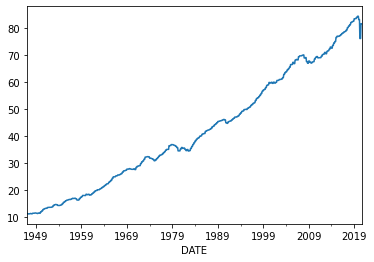

In [34]:
rgdp.fillna(method='ffill').plot()

## Exercise:

Normalize real GDP to year **2000** dollars.

Right now, the unit on the `CPI` variable is "Index 1982-1984=100". This means that "index value" for the Consumer Price *Index* show year is the average of 1982 - 1984.

In [40]:
cpi['1982':'1984'].head(3)

DATE
1982-01-01    94.4
1982-02-01    94.7
1982-03-01    94.7
Name: CPIAUCSL, dtype: float64

In [41]:
# use `.loc[start:end]` or `.loc["<year>"]` to slice a subset of *rows*
cpi.loc['1982':'1984'].mean()  # close enough to 100

100.01666666666667

To *renormalize* an index like CPI, divide the series by the average of a different timespan (say the year 2000) and multiply by 100.

In [46]:
# Get the mean CPI for the year 2000
cpi_2000_average = cpi.loc['2000'].mean()
cpi_2000_average

172.1916666666667

In [50]:
# *renormalize* the entire `cpi` series to "Index 2000" units.
cpi_2000 = 100 * (cpi / cpi_2000_average)
cpi_2000

DATE
1947-01-01     12.474471
1947-02-01     12.555776
1947-03-01     12.776460
1947-04-01     12.776460
1947-05-01     12.747423
                 ...    
2020-05-01    148.536805
2020-06-01    149.376567
2020-07-01    150.252916
2020-08-01    150.809273
2020-09-01    151.115908
Name: CPIAUCSL, Length: 885, dtype: float64

In [51]:
# Compute real GDP again, this time in "year 2000 dollars".
rgdp_2000 = gdp/cpi_2000
rgdp_2000

DATE
1947-01-01     19.492930
1947-02-01           NaN
1947-03-01           NaN
1947-04-01     19.251654
1947-05-01           NaN
                 ...    
2020-05-01           NaN
2020-06-01           NaN
2020-07-01    140.813474
2020-08-01           NaN
2020-09-01           NaN
Length: 885, dtype: float64

In [52]:
# %load solutions/alignment-cpi2000.py
cpi_2000_average = cpi.loc["2000"].mean()

# *renormalize* the entire `cpi` series to "Index 2000" units.
cpi_2000 = 100 * (cpi / cpi_2000_average)

# Compute real GDP again, this time in "year 2000 dollars".
rgdp_2000 = gdp / cpi_2000
rgdp_2000


DATE
1947-01-01     19.492930
1947-02-01           NaN
1947-03-01           NaN
1947-04-01     19.251654
1947-05-01           NaN
                 ...    
2020-05-01           NaN
2020-06-01           NaN
2020-07-01    140.813474
2020-08-01           NaN
2020-09-01           NaN
Length: 885, dtype: float64

## Summary

In pandas, you generally want to have *meaningful row labels*. They should uniquely identify each observation.
Having a unique identifier is just good data hygenie. And since they're in the index they stay out of the way in operations.

## Next Steps

Now we'll discuss [Tidy Data](Tidy.ipynb).